<img style="float: right; margin: 0px 0px 15px 15px;" src="https://educationusa.state.gov/sites/default/files/wysiwyg/iteso_logo.jpg" width="300px" height="300px" />

`Trading Microstructure`

**Ulises Rodrigo León Ortiz**  
**Bryan Edwin Castelan**  
**Paulina Raquel Monroy Salcido** 


## 003 Generative Adversarial Networks

Deliverables:
- Follow a Python Project structure.
- Download 10 years of historical data of a single stock.
- Use the data to train a GAN model that can help us generate multiple scenarios to backtest.
- Create a simple Algorithmic Trading strategy, there's no need to optimize the hyperparameters right now.
- Backtest your strategy using the real data and 100 generated scenarios, testing 10 different stop-loss / take-profit levels.
- Create a benchmark (passive) strategy.
- Measure annual Sharpe's ratio, Calmar Ratio, Max Drawdown, P&L, and Win-Loss ratio, risk-free rate = 0.
- Present ONLY the results & conclusions in a Jupyter notebook (without unnecessary code, only plot-related things), include the list of the operations, candlestick charts, indicators, trading signals, cash through time, portfolio value through time, and any other chart that you consider important.
- Add a table with the measurements of the optimal trading strategy (including the passive strategy).

In [1]:
#Librerias
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TimeDistributed


C:\Users\pmonr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\pmonr\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [22]:
# Define the stock symbol and period
stock_symbol = "COST"  # Costco's stock symbol
start_date = "2014-11-01"
end_date = "2024-11-01"

# Download historical data for the past 10 years with daily frequency
costco_data = yf.download(stock_symbol, start=start_date, end=end_date, interval="1d")

# Display the first few rows of the data to check
print(costco_data.head())


C:\Users\pmonr\anaconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-11-03  133.820007  134.289993  133.369995  134.270004  108.503014   
2014-11-04  134.610001  136.720001  133.990005  136.550003  110.345459   
2014-11-05  137.490005  137.809998  136.029999  136.500000  110.305054   
2014-11-06  137.389999  137.669998  136.600006  137.089996  110.781837   
2014-11-07  137.050003  137.910004  136.520004  137.710007  111.282852   

             Volume  
Date                 
2014-11-03  1947000  
2014-11-04  2802500  
2014-11-05  2116800  
2014-11-06  1685900  
2014-11-07  1589400  


In [23]:
# Extraemos solo los precios de cierre
close_prices = costco_data[['Close']].values
close_prices = np.diff(np.log(close_prices), axis=0)

# Normalizamos los datos entre 0 y 1
log_returns_reshaped = close_prices.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_normalized = scaler.fit_transform(log_returns_reshaped)

# Definimos la longitud de la secuencia (ej. 60 días)
sequence_length = 252 #252 dias


In [47]:
gen_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
disc_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [48]:
def build_generator():
    model = Sequential()
    model.add(Dense(units=300, input_shape=(300,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=512, activation="relu"))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dense(sequence_length, activation='linear'))  # Usamos TimeDistributed para salida en cada paso
    return model


# Configuración del discriminador
def build_discriminator():
    model = Sequential()
    model.add(Dense(units=256, input_shape=(sequence_length, 1), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=1))
    return model


In [49]:
# Crear instancias del generador y discriminador
generator = build_generator()
discriminator = build_discriminator()

# Parámetros de entrenamiento
epochs = 1000 #Menos para que no sea tan pesado eran 1000

years = (len(close_prices_normalized) // 252) - 1
batch_data = close_prices_normalized[:years*252].reshape(-1, 252)

batch_size = len(batch_data)

disc_loss_h = []
gen_loss_h = []

# Entrenamiento de la GAN
for epoch in range(epochs):
    # Generar secuencias sintéticas
    noise = np.random.normal(0, 1, size=(batch_size, 300))
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_sequences = generator(noise, training=True)
        # Entrenar el discriminador (reales como 1 y generadas como 0)
        y_real = discriminator(batch_data, training=True)
        y_fake = discriminator(generated_sequences, training=True)
        d_loss = -(tf.math.reduce_mean(y_real) - tf.math.reduce_mean(y_fake))

        # Entrenar el generador (objetivo: que el discriminador clasifique las secuencias generadas como reales)
        g_loss = - tf.math.reduce_mean(y_fake)
    gen_loss = tf.convert_to_tensor(g_loss)
    disc_loss = tf.convert_to_tensor(d_loss)
    gen_loss_h.append(gen_loss)
    disc_loss_h.append(disc_loss)
    
    
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
    # Imprimir el progreso
    print(f"{epoch} [D loss: {d_loss}, [G loss: {g_loss}]")


0 [D loss: 0.011378731578588486, [G loss: 0.004340626765042543]
1 [D loss: 0.008098860271275043, [G loss: 0.004332193173468113]
2 [D loss: 0.004776125308126211, [G loss: 0.004290957469493151]
3 [D loss: 0.0008618654683232307, [G loss: 0.004752050153911114]
4 [D loss: -0.002532052109017968, [G loss: 0.004380390979349613]
5 [D loss: -0.006150154862552881, [G loss: 0.004715058486908674]
6 [D loss: -0.009680559858679771, [G loss: 0.004628017079085112]
7 [D loss: -0.01340403687208891, [G loss: 0.004790474660694599]
8 [D loss: -0.016987666487693787, [G loss: 0.004759365692734718]
9 [D loss: -0.021148955449461937, [G loss: 0.005521393846720457]
10 [D loss: -0.023924726992845535, [G loss: 0.004930144175887108]
11 [D loss: -0.02698751538991928, [G loss: 0.004631060641258955]
12 [D loss: -0.03015042282640934, [G loss: 0.005019692704081535]
13 [D loss: -0.03361931070685387, [G loss: 0.005083790514618158]
14 [D loss: -0.035856880247592926, [G loss: 0.004130541812628508]
15 [D loss: -0.039402026683

128 [D loss: 0.08130326867103577, [G loss: 0.08192034065723419]
129 [D loss: 0.06488478183746338, [G loss: 0.09504123032093048]
130 [D loss: 0.0719171017408371, [G loss: 0.08321870863437653]
131 [D loss: 0.068821981549263, [G loss: 0.08228237926959991]
132 [D loss: 0.06021995097398758, [G loss: 0.08631210774183273]
133 [D loss: 0.051449500024318695, [G loss: 0.09052247554063797]
134 [D loss: 0.04712629318237305, [G loss: 0.09149546921253204]
135 [D loss: 0.038408100605010986, [G loss: 0.09490680694580078]
136 [D loss: 0.027881473302841187, [G loss: 0.10041016340255737]
137 [D loss: 0.019029371440410614, [G loss: 0.10513535887002945]
138 [D loss: 0.012379802763462067, [G loss: 0.10877335071563721]
139 [D loss: 0.0039713457226753235, [G loss: 0.11225103586912155]
140 [D loss: -0.007859140634536743, [G loss: 0.12045133858919144]
141 [D loss: -0.010235406458377838, [G loss: 0.11981656402349472]
142 [D loss: -0.023451730608940125, [G loss: 0.1299172043800354]
143 [D loss: -0.029961615800857

254 [D loss: -0.028220796957612038, [G loss: 0.028069855645298958]
255 [D loss: -0.03189331665635109, [G loss: 0.03073682077229023]
256 [D loss: -0.022414501756429672, [G loss: 0.022257236763834953]
257 [D loss: -0.015323920175433159, [G loss: 0.014806730672717094]
258 [D loss: -0.027536867186427116, [G loss: 0.026697920635342598]
259 [D loss: -0.02776147797703743, [G loss: 0.027724551036953926]
260 [D loss: -0.02581467479467392, [G loss: 0.02367262914776802]
261 [D loss: -0.02722828835248947, [G loss: 0.026104886084794998]
262 [D loss: -0.029611410573124886, [G loss: 0.02802637219429016]
263 [D loss: -0.030345622450113297, [G loss: 0.028794249519705772]
264 [D loss: -0.04296848177909851, [G loss: 0.04072830453515053]
265 [D loss: -0.0387926809489727, [G loss: 0.037298914045095444]
266 [D loss: -0.039068061858415604, [G loss: 0.03840204328298569]
267 [D loss: -0.038583509624004364, [G loss: 0.03864071145653725]
268 [D loss: -0.041480984538793564, [G loss: 0.04258233681321144]
269 [D lo

380 [D loss: -0.036318667232990265, [G loss: 0.054050981998443604]
381 [D loss: -0.032696325331926346, [G loss: 0.05192171409726143]
382 [D loss: -0.018686626106500626, [G loss: 0.040830325335264206]
383 [D loss: -0.03513803333044052, [G loss: 0.06037985160946846]
384 [D loss: -0.02933846041560173, [G loss: 0.05960209295153618]
385 [D loss: -0.025084026157855988, [G loss: 0.05653022229671478]
386 [D loss: -0.03432059660553932, [G loss: 0.0683121383190155]
387 [D loss: -0.011052951216697693, [G loss: 0.047067172825336456]
388 [D loss: -0.015138756483793259, [G loss: 0.05264902859926224]
389 [D loss: -0.02397923171520233, [G loss: 0.06032535061240196]
390 [D loss: -0.02374083548784256, [G loss: 0.059899888932704926]
391 [D loss: -0.016664862632751465, [G loss: 0.050697289407253265]
392 [D loss: -0.03479848802089691, [G loss: 0.06620136648416519]
393 [D loss: -0.04130998253822327, [G loss: 0.06830786168575287]
394 [D loss: -0.04158490523695946, [G loss: 0.06619814783334732]
395 [D loss: -

506 [D loss: -0.018809176981449127, [G loss: 0.04620959237217903]
507 [D loss: -0.0291144959628582, [G loss: 0.05872775614261627]
508 [D loss: -0.015313131734728813, [G loss: 0.044582899659872055]
509 [D loss: -0.0138713289052248, [G loss: 0.04383857548236847]
510 [D loss: -0.010779906064271927, [G loss: 0.040384385734796524]
511 [D loss: -0.01666400581598282, [G loss: 0.04563117399811745]
512 [D loss: -0.001444859430193901, [G loss: 0.030213909223675728]
513 [D loss: -0.01732550375163555, [G loss: 0.04504220187664032]
514 [D loss: -0.01870434544980526, [G loss: 0.046295415610075]
515 [D loss: -0.03335998207330704, [G loss: 0.061161357909440994]
516 [D loss: -0.03407565504312515, [G loss: 0.06176067888736725]
517 [D loss: -0.04407868534326553, [G loss: 0.07143453508615494]
518 [D loss: -0.021955356001853943, [G loss: 0.049917250871658325]
519 [D loss: -0.011525951325893402, [G loss: 0.04076031967997551]
520 [D loss: -0.020797744393348694, [G loss: 0.0528993159532547]
521 [D loss: -0.02

632 [D loss: -0.0316678062081337, [G loss: 0.06972158700227737]
633 [D loss: -0.028128482401371002, [G loss: 0.06584387272596359]
634 [D loss: -0.0019305162131786346, [G loss: 0.04055202752351761]
635 [D loss: -0.026905767619609833, [G loss: 0.06667028367519379]
636 [D loss: -0.023019898682832718, [G loss: 0.062273185700178146]
637 [D loss: -0.002898905426263809, [G loss: 0.04457514360547066]
638 [D loss: -0.03308561071753502, [G loss: 0.07548236101865768]
639 [D loss: -0.017718367278575897, [G loss: 0.06127381697297096]
640 [D loss: -0.024087272584438324, [G loss: 0.07047008723020554]
641 [D loss: -0.025596655905246735, [G loss: 0.0723532885313034]
642 [D loss: -0.015785999596118927, [G loss: 0.0635220929980278]
643 [D loss: -0.037303678691387177, [G loss: 0.08394842594861984]
644 [D loss: -0.007407613098621368, [G loss: 0.051023803651332855]
645 [D loss: -0.009753037244081497, [G loss: 0.05304908752441406]
646 [D loss: -0.02255462110042572, [G loss: 0.06384968012571335]
647 [D loss: 

757 [D loss: -0.010295253247022629, [G loss: 0.06871768087148666]
758 [D loss: 0.0102195143699646, [G loss: 0.04661305621266365]
759 [D loss: -0.016448568552732468, [G loss: 0.06998475641012192]
760 [D loss: -0.06229308992624283, [G loss: 0.11177576333284378]
761 [D loss: -0.024363752454519272, [G loss: 0.07010390609502792]
762 [D loss: -0.03345656022429466, [G loss: 0.0785173550248146]
763 [D loss: -0.0005738809704780579, [G loss: 0.03984212875366211]
764 [D loss: -0.015654265880584717, [G loss: 0.05732959508895874]
765 [D loss: -0.020553842186927795, [G loss: 0.06258679926395416]
766 [D loss: -0.016340453177690506, [G loss: 0.05916447937488556]
767 [D loss: -0.034428730607032776, [G loss: 0.08012637495994568]
768 [D loss: 0.019367102533578873, [G loss: 0.02765009179711342]
769 [D loss: -0.013383481651544571, [G loss: 0.06157189607620239]
770 [D loss: 0.00826793909072876, [G loss: 0.040971193462610245]
771 [D loss: -0.020865265280008316, [G loss: 0.06900596618652344]
772 [D loss: -0.0

883 [D loss: -0.018733538687229156, [G loss: 0.05996864661574364]
884 [D loss: 0.010648434981703758, [G loss: 0.030725250020623207]
885 [D loss: 0.014393609017133713, [G loss: 0.030814889818429947]
886 [D loss: 0.009265176951885223, [G loss: 0.0380057729780674]
887 [D loss: -0.003989577293395996, [G loss: 0.05282878130674362]
888 [D loss: -0.010276004672050476, [G loss: 0.05845082923769951]
889 [D loss: -0.03628983721137047, [G loss: 0.08556865900754929]
890 [D loss: -0.019979912787675858, [G loss: 0.06731054186820984]
891 [D loss: -0.0105738565325737, [G loss: 0.05380357429385185]
892 [D loss: -0.011144973337650299, [G loss: 0.05539259314537048]
893 [D loss: 0.014003423973917961, [G loss: 0.027684124186635017]
894 [D loss: -0.024007312953472137, [G loss: 0.0629972368478775]
895 [D loss: -0.019432861357927322, [G loss: 0.060189828276634216]
896 [D loss: -0.033998847007751465, [G loss: 0.07437609136104584]
897 [D loss: -0.00033986568450927734, [G loss: 0.042365897446870804]
898 [D loss:

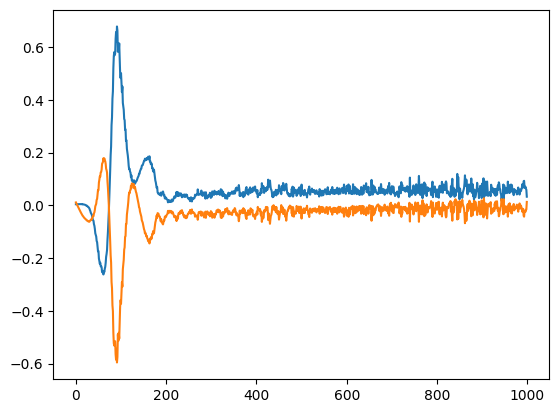

In [50]:
plt.plot(gen_loss_h)
plt.plot(disc_loss_h)

In [61]:
generator(np.random.normal(size=(1, 300)), training=False)

<tf.Tensor: shape=(1, 252), dtype=float32, numpy=
array([[0.57005715, 0.6033713 , 0.59007037, 0.5427767 , 0.5363608 ,
        0.5954489 , 0.55941623, 0.5292088 , 0.50531197, 0.5392492 ,
        0.5123429 , 0.5133115 , 0.5356464 , 0.55190307, 0.6008074 ,
        0.5425998 , 0.5765874 , 0.57188106, 0.5055898 , 0.579301  ,
        0.51640964, 0.47279674, 0.5442632 , 0.54797095, 0.5374524 ,
        0.5486979 , 0.49389482, 0.55162615, 0.54044825, 0.5034426 ,
        0.50997853, 0.49922505, 0.5183007 , 0.5323363 , 0.5410337 ,
        0.5371308 , 0.5056976 , 0.57465595, 0.5521811 , 0.53952634,
        0.49475104, 0.53131175, 0.5360943 , 0.48555836, 0.57103896,
        0.56314015, 0.5334568 , 0.5229175 , 0.5701662 , 0.55864704,
        0.57136536, 0.5294529 , 0.5123272 , 0.5132277 , 0.5138297 ,
        0.5514838 , 0.58638453, 0.52637386, 0.53412277, 0.54376036,
        0.49645078, 0.5677103 , 0.52008873, 0.51496255, 0.5256828 ,
        0.5294837 , 0.53090626, 0.43557307, 0.55142003, 0.5155756 

In [66]:
# Generar secuencias de precios sintéticas
n_scenarios = 100 # Eran 100 pero lo disminuyo para que sea más fácil
generated_scenarios = []

for _ in range(n_scenarios):
    noise = np.random.normal(0, 1, (1, 300))
    generated_sequence = generator(noise).numpy()
    generated_scenarios.append(generated_sequence[0])  # Ajusta el tamaño aquí

# Convertir a un arreglo numpy y deshacer la normalización para tener valores reales
generated_scenarios = np.array(generated_scenarios)  # Ahora tendrá la forma (10, 60)
generated_scenarios = scaler.inverse_transform(generated_scenarios)



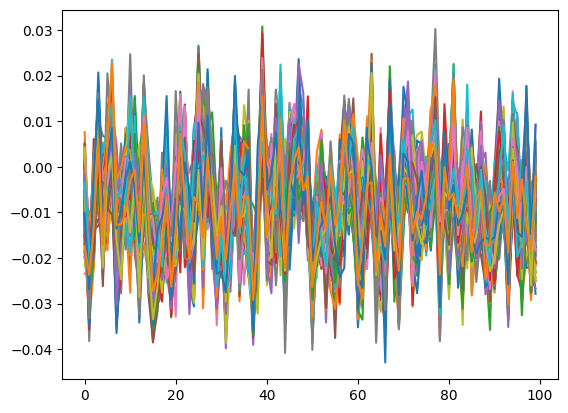

In [68]:
plt.plot(generated_scenarios)
plt.show()

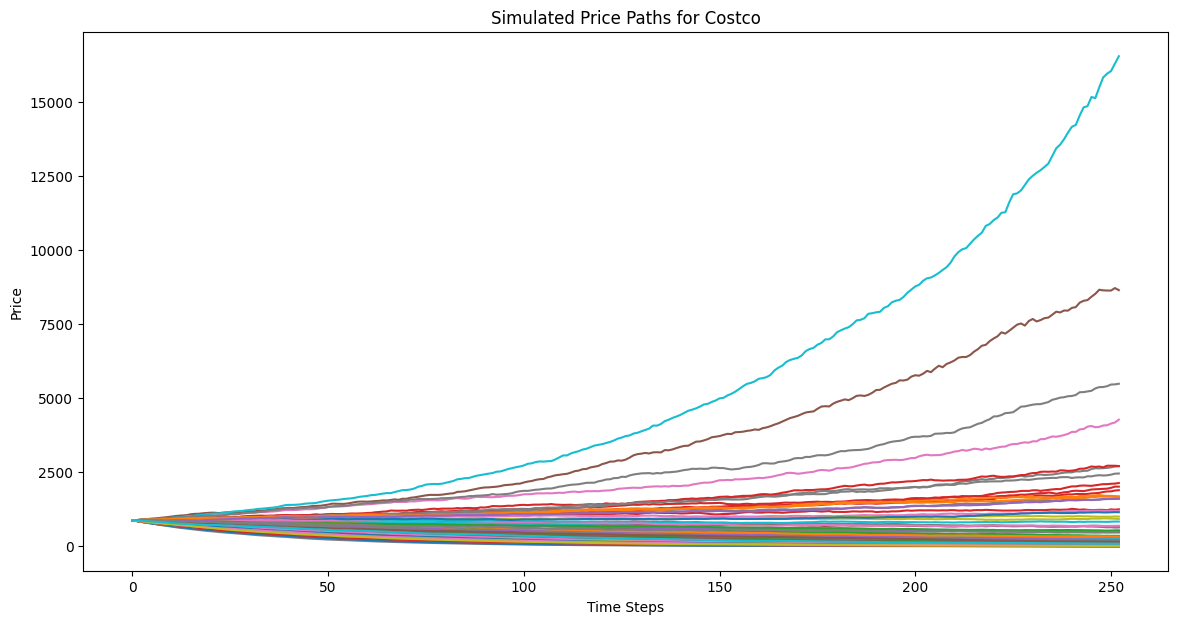

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que 'generated_scenarios' es un array de NumPy con tus 100 escenarios de rendimientos logarítmicos
# Cada fila representa un escenario diferente y cada columna un paso de tiempo

# Convertir rendimientos logarítmicos a simples
simple_returns = np.exp(generated_scenarios) - 1

# Suponemos que tienes un precio inicial, que es el último precio conocido de la acción
initial_price = costco_data['Close'].iloc[-1]

# Preparar el array para almacenar los precios simulados
num_scenarios = simple_returns.shape[0]
num_steps = simple_returns.shape[1]
simulated_prices = np.zeros((num_scenarios, num_steps + 1))  # +1 para incluir el precio inicial en cada escenario

# Calcular los precios para cada escenario
for i in range(num_scenarios):
    prices = [initial_price]
    for return_ in simple_returns[i]:
        prices.append(prices[-1] * (1 + return_))
    simulated_prices[i] = prices

# Graficar los resultados para visualizar algunos de los escenarios
plt.figure(figsize=(14, 7))
for i in range(min(num_scenarios, 100)):  # Graficar solo los primeros 10 escenarios para claridad
    plt.plot(simulated_prices[i], label=f'Scenario {i+1}')
plt.title('Simulated Price Paths for Costco')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()

In [134]:
import pandas as pd
import numpy as np

# Valores de take profit y stop loss a probar
take_profit_stop_loss_values = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.15]

# Función para calcular el RSI
def calculate_rsi(data, window=4):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

# Función para calcular métricas de rendimiento
def calculate_metrics(portfolio_values):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Rendimientos diarios

    # 1. Sharpe Ratio (anualizado)
    sharpe_ratio = (np.mean(returns) / np.std(returns)) * np.sqrt(252) if np.std(returns) != 0 else 0

    # 2. Calmar Ratio
    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values)
    calmar_ratio = (np.mean(returns) * 252) / max_drawdown if max_drawdown != 0 else 0

    # 3. Max Drawdown
    max_drawdown_pct = max_drawdown / np.maximum.accumulate(portfolio_values).max()

    # 4. Profit & Loss (P&L)
    pnl = portfolio_values[-1] - portfolio_values[0]

    # 5. Win-Loss Ratio
    win_ratio = np.sum(returns > 0) / len(returns) if len(returns) > 0 else 0

    return sharpe_ratio, calmar_ratio, max_drawdown_pct, pnl, win_ratio

# Función de backtesting con diferentes niveles de take profit y stop loss y cálculo de métricas
def backtest_strategy_rsi(data, take_profit, stop_loss, rsi_buy_threshold=30, rsi_sell_threshold=70):
    position_open = False
    entry_price = 0
    cash = 10000
    shares = 0
    portfolio_values = [cash]  # Almacenar el valor diario del portafolio

    for i in range(len(data)):
        price = data['Close'].iloc[i]

        # Señal de compra (RSI por debajo del umbral de compra)
        if not position_open and data['RSI'].iloc[i] < rsi_buy_threshold:
            position_open = True
            entry_price = price
            shares = cash / entry_price

        # Señal de venta (RSI por encima del umbral de venta o condiciones de take-profit / stop-loss)
        elif position_open:
            if (price >= entry_price * (1 + take_profit)) or (price <= entry_price * (1 - stop_loss)) or (data['RSI'].iloc[i] > rsi_sell_threshold):
                position_open = False
                cash = shares * price
                shares = 0

        # Registrar el valor del portafolio diario
        portfolio_value = cash if not position_open else shares * price
        portfolio_values.append(portfolio_value)

    # Calcular las métricas finales del portafolio
    sharpe_ratio, calmar_ratio, max_drawdown, pnl, win_loss_ratio = calculate_metrics(portfolio_values)
    return sharpe_ratio, calmar_ratio, max_drawdown, pnl, win_loss_ratio

# Crear un DataFrame para almacenar los resultados
results = []

# Aplicar el backtest en cada escenario con diferentes niveles de take profit y stop loss
for i, scenario_data in enumerate(simulated_prices):
    # Convertir los datos del escenario a DataFrame y calcular el RSI
    scenario_df = pd.DataFrame(scenario_data, columns=['Close'])
    scenario_df = calculate_rsi(scenario_df)
    
    # Probar cada combinación de take profit y stop loss
    for tp_sl in take_profit_stop_loss_values:
        sharpe_ratio, calmar_ratio, max_drawdown, pnl, win_loss_ratio = backtest_strategy_rsi(scenario_df, take_profit=tp_sl, stop_loss=tp_sl)
        
        # Guardar el resultado
        results.append({
            'Escenario': i + 1,
            'Take_Profit_Stop_Loss': tp_sl,
            'Sharpe_Ratio_Anual': sharpe_ratio,
            'Calmar_Ratio': calmar_ratio,
            'Max_Drawdown': max_drawdown,
            'P&L': pnl,
            'Win_Loss_Ratio': win_loss_ratio
        })

# Convertir los resultados en un DataFrame
df_results = pd.DataFrame(results)

# Guardar el DataFrame con los resultados o mostrar los primeros resultados
# df_results.to_csv("resultados_estrategia_rsi_métricas.csv", index=False)
df_results.head(100)

,Escenario,Take_Profit_Stop_Loss,Sharpe_Ratio_Anual,Calmar_Ratio,Max_Drawdown,P&L,Win_Loss_Ratio
0,1,0.05,-18.405623,-0.000208,0.822695,-8226.947741,0.079051
1,1,0.06,-18.439952,-0.000210,0.827375,-8273.748212,0.086957
2,1,0.07,-18.736815,-0.000209,0.823653,-8236.527271,0.094862
3,1,0.08,-18.991153,-0.000213,0.834260,-8342.597318,0.086957
4,1,0.09,-19.339665,-0.000217,0.842256,-8422.559787,0.090909
...,...,...,...,...,...,...,...
95,10,0.10,-13.279596,-0.000161,0.653773,-6537.734667,0.169960
96,10,0.11,-13.137634,-0.000159,0.645767,-6457.669122,0.173913
97,10,0.12,-13.397667,-0.000161,0.655615,-6556.145405,0.169960
98,10,0.13,-13.452933,-0.000161,0.657253,-6572.529726,0.169960


In [136]:
# Agrupar por 'Escenario' y calcular el promedio de cada métrica
df_grouped = df_results.groupby('Escenario').mean().reset_index()

# Mostrar los resultados agrupados
df_grouped.head()

,Escenario,Take_Profit_Stop_Loss,Sharpe_Ratio_Anual,Calmar_Ratio,Max_Drawdown,P&L,Win_Loss_Ratio
0,1,0.096,-19.443001,-0.000216,0.838811,-8388.108687,0.086957
1,2,0.096,-29.428107,-0.000459,0.989859,-9898.589368,0.010277
2,3,0.096,-23.525262,-0.000242,0.885251,-8852.513298,0.027668
3,4,0.096,3.653104,0.005408,0.001964,1270.731400,0.086957
4,5,0.096,-20.472478,-0.000242,0.885383,-8853.829655,0.058103


In [125]:
# Calcular el P&L de la estrategia pasiva para cada escenario
passive_results = []
for i, scenario_data in enumerate(simulated_prices):
    scenario_df = pd.DataFrame(scenario_data, columns=['Close'])
    initial_cash = 10000
    initial_price = scenario_df['Close'].iloc[0]
    final_price = scenario_df['Close'].iloc[-1]
    shares = initial_cash / initial_price
    final_value = shares * final_price
    pnl_passive = final_value - initial_cash

    # Guardar el resultado de la estrategia pasiva
    passive_results.append({
        'Escenario': i + 1,
        'Passive_P&L': pnl_passive
    })
    
# Convertir los resultados de la estrategia pasiva en un DataFrame
df_passive_results = pd.DataFrame(passive_results)

In [126]:
df_passive_results 

,Escenario,Passive_P&L
0,1,-8656.354034
1,2,-9964.156956
2,3,-9082.060941
3,4,11631.434920
4,5,-9065.513551
...,...,...
95,96,-8280.390713
96,97,-9773.947334
97,98,-4559.019033
98,99,-9887.492103


In [127]:
df_combined = pd.merge(df_grouped, df_passive_results, on='Escenario')
df_combined

,Escenario,Take_Profit_Stop_Loss,Sharpe_Ratio_Anual,Calmar_Ratio,Max_Drawdown,P&L,Win_Loss_Ratio,Passive_P&L
0,1,0.096,-19.443001,-0.000216,0.838811,-8388.108687,0.086957,-8656.354034
1,2,0.096,-29.428107,-0.000459,0.989859,-9898.589368,0.010277,-9964.156956
2,3,0.096,-23.525262,-0.000242,0.885251,-8852.513298,0.027668,-9082.060941
3,4,0.096,3.653104,0.005408,0.001964,1270.731400,0.086957,11631.434920
4,5,0.096,-20.472478,-0.000242,0.885383,-8853.829655,0.058103,-9065.513551
...,...,...,...,...,...,...,...,...
95,96,0.096,-13.760336,-0.000196,0.793861,-7936.120704,0.171542,-8280.390713
96,97,0.096,-27.730513,-0.000335,0.961546,-9615.455614,0.007510,-9773.947334
97,98,0.096,-4.416225,-0.000114,0.369523,-3505.307577,0.275099,-4559.019033
98,99,0.096,-29.740550,-0.000384,0.977204,-9772.043369,0.006324,-9887.492103


# Calmar Ratio

El **Calmar Ratio** es una métrica de rendimiento ajustada al riesgo utilizada para evaluar la rentabilidad de una estrategia de inversión en relación con el riesgo que implica. Esta métrica es especialmente útil para medir el desempeño de estrategias que pueden enfrentar pérdidas significativas en periodos de alta volatilidad.

### Componentes

1. **Rendimiento Anualizado**: Representa el rendimiento promedio anual que la estrategia ha generado.
2. **Máxima Caída (Max Drawdown)**: Es la mayor pérdida desde un punto máximo a un punto mínimo en el valor de la estrategia, reflejando el riesgo de pérdidas grandes.

### Interpretación

Un **Calmar Ratio alto** indica una mejor relación entre el rendimiento y el riesgo. Esto significa que la estrategia genera buenos rendimientos en comparación con sus caídas máximas, lo cual es ideal para los inversionistas que buscan un balance entre rendimiento y riesgo.

#### Valores del Calmar Ratio
- **Calmar Ratio > 1**: Generalmente se considera bueno, ya que el rendimiento anualizado supera la pérdida máxima.
- **Calmar Ratio cercano a 1**: Indica un equilibrio entre el rendimiento y la pérdida máxima.
- **Calmar Ratio < 1**: Sugiere que la pérdida máxima es mayor que el rendimiento anual, lo que puede indicar un mayor riesgo en la estrategia.



Estrategia con mayor Calmar_Ratio':
Escenario                   4.000000
Take_Profit_Stop_Loss       0.050000
Sharpe_Ratio_Anual          3.653104
Calmar_Ratio                0.005408
Max_Drawdown                0.001964
P&L                      1270.731400
Win_Loss_Ratio              0.086957
Name: 30, dtype: float64


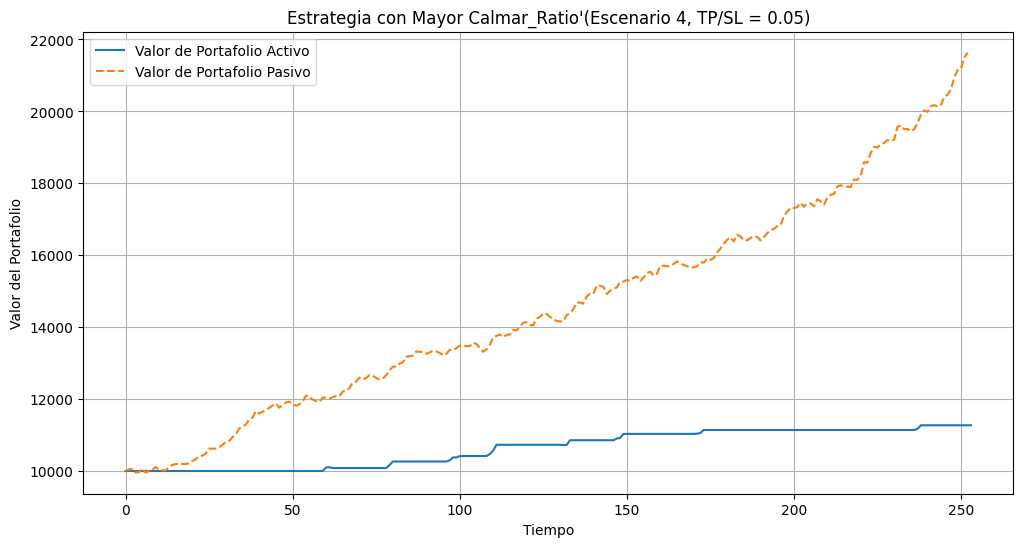

In [140]:
import matplotlib.pyplot as plt

# Encontrar la estrategia con la mayor ganancia en P&L
max_pnl_row = df_results.loc[df_results['Calmar_Ratio'].idxmax()]

# Mostrar la información de la estrategia con mayor ganancia
print("Estrategia con mayor Calmar_Ratio':")
print(max_pnl_row)

# Extraer el escenario y los parámetros de take profit y stop loss de la estrategia con mayor P&L
escenario_max_pnl = int(max_pnl_row['Escenario'])  # Asegurarse de que sea un entero
take_profit_stop_loss = max_pnl_row['Take_Profit_Stop_Loss']

# Filtrar los datos del escenario correspondiente en simulated_prices
scenario_data = simulated_prices[escenario_max_pnl - 1]  # -1 porque el índice empieza en 0
scenario_df = pd.DataFrame(scenario_data, columns=['Close'])

# Cálculo del valor del portafolio de la estrategia activa
def calculate_active_portfolio(data, take_profit, stop_loss):
    position_open = False
    entry_price = 0
    cash = 10000
    shares = 0
    portfolio_values = [cash]

    for i in range(len(data)):
        price = data['Close'].iloc[i]

        # Señal de compra (RSI por debajo del umbral de compra)
        if not position_open and data['RSI'].iloc[i] < 30:  # Umbral de compra para RSI
            position_open = True
            entry_price = price
            shares = cash / entry_price

        # Señal de venta (RSI por encima del umbral de venta o condiciones de take-profit / stop-loss)
        elif position_open:
            if (price >= entry_price * (1 + take_profit)) or (price <= entry_price * (1 - stop_loss)) or (data['RSI'].iloc[i] > 70):
                position_open = False
                cash = shares * price
                shares = 0

        # Registrar el valor del portafolio diario
        portfolio_value = cash if not position_open else shares * price
        portfolio_values.append(portfolio_value)

    return portfolio_values

# Calcular el valor del portafolio de la estrategia activa
scenario_df = calculate_rsi(scenario_df)  # Calcular RSI si es necesario
active_portfolio_values = calculate_active_portfolio(scenario_df, take_profit_stop_loss, take_profit_stop_loss)

# Calcular el valor del portafolio de la estrategia pasiva
initial_cash = 10000
initial_price = scenario_df['Close'].iloc[0]
shares = initial_cash / initial_price
passive_portfolio_values = shares * scenario_df['Close']

# Graficar ambos portafolios
plt.figure(figsize=(12, 6))
plt.plot(active_portfolio_values, label='Valor de Portafolio Activo')
plt.plot(passive_portfolio_values, label='Valor de Portafolio Pasivo', linestyle='--')

# Configuración del gráfico
plt.title(f"Estrategia con Mayor Calmar_Ratio'(Escenario {escenario_max_pnl}, TP/SL = {take_profit_stop_loss})")
plt.xlabel("Tiempo")
plt.ylabel("Valor del Portafolio")
plt.legend()
plt.grid()
plt.show()


# Conclusiones


En este proyecto, utilizamos Redes Generativas Antagónicas (GAN) para simular múltiples escenarios de precios de la acción de Costco. Estas simulaciones nos permitieron generar datos sintéticos que mantienen las mismas propiedades estadísticas que los datos históricos, brindando una base robusta para realizar backtests. A través de estos escenarios, evaluamos la estrategia con diferentes niveles de *stop loss* y *take profit* y calculamos métricas como el Calmar ratio, Sharpe ratio y Max Drawdown, seleccionando y graficando la estrategia que obtuvo el mejor Calmar ratio. Este enfoque es particularmente útil para realizar un análisis exhaustivo cuando la información disponible es limitada, ya que permite crear una amplia variedad de escenarios sobre los cuales evaluar el rendimiento de una estrategia de trading.
